# Core 2020
# Taller Introducción al aprendizaje por refuerzo profundo para juegos en atari
## Libreta de métodos de predicción y control libres de modelo.
*Por Roberto López-Díaz*



In [1]:
import matplotlib.pyplot as plt
import numpy as np
from abc import ABC

### Declarar los entornos de la clase pasada

Para los primeros dos métodos seguiremos utilizando el ultimo entorno de StochasticGridWorld. 

In [2]:
class actionSpace(ABC):
    """
    Discrete Action Space class.
    Stores all the posible actions for an environment and can generate
    samples with the method sample().

    Parameters
    ----------
    n: int
        Number of total actions. These are consider to be sequential.
    minValue: int
        Default 0. The minimum value that the action can take. It's
        the lower inclusive of the action space intervals 
        [minValue, minValue + n)
    """
    def __init__(self, n:int, minValue:int=0):
        assert n > 0, "Number of actions must be greater than 0"
        self.n = n
        self.mV = minValue
    
    @property
    def shape(self):
        return self.n

    def __iter__(self):
        self.actions = []
        self.i = 0
        for i in range(self.n):
            self.actions += [self.mV + i]
        return self
    
    def __next__(self):
        if self.i == self.n:
            raise StopIteration
        nx = self.actions[self.i]
        self.i += 1
        return nx

    def sample(self):
        """
        Returns a random sample with an uniform distribution of the
        actions.
        """
        return np.random.randint(self.mV, self.mV + self.n)

class Environment(ABC):
    """
    Environment base class.
    """
    def step(self, action):
        """
        Executes the action, updates the environment, calculates de reward and observation output.
        Returns
        -------
        observation, reward, done
        """
        raise NotImplemented
    def reset(self):
        """
        Restart the initial state of the environment, in a deterministic or stochastic manner
        Returns
        ------
        obeservation
        """
        raise NotImplemented
    def getObservation(self):
        """
        Calculates and returns the observation of the actual state of the environment.
        """
        raise NotImplemented
    def calculateReward(self, state):
        """
        Calculate with the actual mode the reward from the last observation made in the environment

        Returns
        -------
        reward
        """
        raise NotImplemented
    @property
    def actionSpace(self):
        """
        Returns the ActionShape class designed of the environment.
        """
        raise NotImplemented
    @property
    def stateSpace(self):
        """
        Returns a list or generator of all the states availables. 
        """
        raise NotImplemented
    def transProb(self, state, action):
        """
        Returns the probabilities and states of the transitions from the
        state and action given.
        """
        raise NotImplemented
    def isTerminal(self, state):
        """
        Returns the bool that expreses if the actual state is a terminal one
        or not.
        """
        raise NotImplemented


class Policy(ABC):
    """
    Policy base class.
    """
    def getAction(self, state):
        """
        Calculates and returns the corresponding action for the state given.
        """
        raise NotImplemented
    def update(self, state, action):
        """
        Update the action per state manner of the policy
        """
        raise NotImplemented
    @property
    def shape(self):
        """
        From the tabular values, returns the shape of the 
        input state required
        """
        raise NotImplemented

In [3]:
class gridWorld(Environment):
    """
    Little and simple environment for a deterministic grid world.
    Parameters
    ----------
    width: int
        First dimension of the grid
    height: int
        Second dimension of the grid
    initPos: tuple of int
        Initial position of the agent.
    goal: tuple of int
        Position of the first goal to create the grid.
        One can add more goals later if required.
    movement: str
        Default 8C. Refer to step method.
    horizon: int
        Default 10**2. Number of steps to run the environment before it
        terminates.
    """
    # All gfx related
    EMPTYC = (255, 255, 255)
    OBST = 2
    OBSTC = (128, 64, 64)
    VORTEX = 3
    VORTEXC = (230, 0, 10)
    GOAL = 1
    GOALC = (0, 200, 20)
    AGENTC = (230, 150, 240)
    POLICYC = (0, 1, 0.5)
    CELLSIZE = 4
    GRAPHSCALE = 1.2    

    VORTEXD = [[False, True, True, False],
             [True, False, False, True],
             [True, False, False, True],
             [False, True, True, False]]

    AGENTD = [[False, True, True, False],
              [True, True, True, True],
              [True, True, True, True],
              [False, True, True, False]]

    GOALD = [[True, False, True, False],
             [False, True, False, True],
             [True, False, True, False],
             [False, True, False, True]]

    # Action meaning related
    actions  = [(-1,-1),(-1, 0),(-1,1),
              (0, -1),(0, 0),(0, 1),
              (1, -1),(1, 0),(1, 1)]

    actions4C = [1,3,4,5,7]

    def __init__(self, width:int, height:int, initPos:tuple, goal:tuple, movement:str = "4C", horizon:int = 10**2):
        # Grid Related
        self.grid = np.zeros((width, height), dtype=np.uint8)
        self._w = width
        self._h = height
        self.obstacles = []
        self.vortex = []
        self.goal = [goal]
        self.steps = 0
        self.gameOver = False
        self.horizon = horizon
        # Agent related
        self.movMode = movement
        self.validateTuple(initPos)
        self.initX, self.initY = initPos
        self.posX, self.posY = initPos
        self.__actionSpace = actionSpace(9 if movement == "8C" else 5, 1)
        # Graphics related
        self.frame = np.zeros((width * self.CELLSIZE, height * self.CELLSIZE, 3), dtype=np.uint8)
        # Initialize the grid
        self.reset()

    def validateTuple(self, T:tuple):
        assert len(T) == 2, "Tuple needs to have 2 items for x and y"
        if (T[0] < 0) or (T[1] < 0):
            raise ValueError("Values of the tuple must be non-negative")
        if (T[0] >= self._w) or (T[1] >= self._h):
            raise ValueError("Value of the tuple need to be in the interval x[0, {}), y[0, {})".format(self._w, self._h))
        return True
    
    def addVortex(self, *vortex):
        """
        Add a vortex on the grid
        Parameters
        ---------
        vortex: tuple of int
            A tuple of integers that cointains the position in which one 
            desire to put a new vortex.
        """
        for v in vortex:
            self.validateTuple(v)
            self.vortex += [v]

    def addObstacles(self, *obstacles):
        """
        Add an obstacle on the grid
        Parameters
        ---------
        obstacles: tuple of int
            A tuple of integers that cointains the position in which one 
            desire to put a new obstacle.
        """
        for o in obstacles:
            self.validateTuple(o)
            self.obstacles += [o]
    
    def addGoals(self, *goals):
        """
        Add a goal on the grid
        Parameters
        ---------
        goal: tuple of int
            A tuple of integers that cointains the position in which one 
            desire to put an additional goal.
        """
        for g in goals:
            self.validateTuple(g)
            self.goals += [g]

    def reset(self, initialPos = None):
        self.grid[:,:] = 0
        for o in self.obstacles:
            self.grid[o] = self.OBST
        for v in self.vortex:
            self.grid[v] = self.VORTEX
        for g in self.goal:
            self.grid[g] = self.GOAL
        if initialPos is None:
            self.posX = self.initX
            self.posY = self.initY
        else:
            self.validateTuple(initialPos)
            if not self.validateStart(initialPos):
                return None
            self.posX, self.posY = initialPos
        self.steps = 0
        self.gameOver = False
        self.lastObs = self.getObservation()
        self.lastReward = 0
        self.lastAction = 5
        return self.lastObs

    def step(self, action:int = 5):
        """
        Excecute a step on the environment. 
        The actions on the grid that the agent can take on mode 8C are
        integers from 1 to 9.

            [1  2  3]
            |4  5  6|
            [7  8  9]

        5 being the neutral action or "Do nothing"

        In mode 4C, the action space is reduced to just move in a cross 
        pattern with integers from 1 to 5

            [-  1  -]
            |2  3  4|
            [-  5  -]
        
        3 being the "do nothing" action.

        Parameters
        ----------
        action: int
            
        Returns
        -------
        observation , reward, done
        """
        # If the environment has reached a terminal state
        if self.gameOver:
            return self.lastObs, 0, True
        # Select the action from the corresponding transition probabilities
        randomSelect = np.random.uniform(0,1)
        probs, states = self.transProb(self.lastObs, action)
        lastP = 0
        for p, s in zip(probs, states):
            if randomSelect <= (p + lastP):
                self.posX, self.posY = s
                break
            else:
                lastP += p
        self.steps += 1
        # Check the horizon
        if self.steps > self.horizon:
            self.gameOver = True
        # Get new state and reward
        self.lastObs = self.getObservation(copy = False)
        self.lastReward = self.calculateReward(self.lastObs)
        return self.lastObs, self.lastReward, self.gameOver

    def validateAction(self, state, action:int):
        if self.movMode == "8C":
            assert (action > 0) and (action < 10), "Action must be an integer between 1 and 9"
            dx, dy = self.actions[action - 1]
        elif self.movMode == "4C":
            assert (action > 0) and (action < 6), "Action must be an integer between 1 and 5"
            dx, dy = self.actions[self.actions4C[action - 1]]
        self.lastAction = action
        posX, posY = state["agent"]
        # Tentative new position
        posX += dx
        posY += dy
        # Checking the movements be inside the grid
        if (posX < 0) or (posX >= self._w) or (posY < 0) or (posY >= self._h):
            # Is not inside the grid, this does nothing
            return state["agent"]
        # Checking if the movement gets it to an obstacle
        elif self.grid[posX, posY] == self.OBST:
            # Returns the same position as before
            return state["agent"]
        else:
            # No obstacle the new position is returned
            return posX, posY
    
    def calculateReward(self, state):
        # For each movement
        reward = -1 
        cellAgent = self.grid[state["agent"]]
        if cellAgent == self.VORTEX:
            # The agent has enter a vortex.
            reward += - 14
            self.gameOver = True
        elif cellAgent == self.GOAL:
            reward += 11
            self.gameOver = True
        return reward 

    def getObservation(self, copy:bool = True):
        if copy:
            return {"agent":(self.posX, self.posY), 
                    "grid": np.copy(self.grid)}
        else:
            return {"agent":(self.posX, self.posY), 
                    "grid": self.grid}

    def render(self, values=None, policy=None):
        # Suboptimal but simple to understand graphics for the environment
        fig = plt.figure(figsize=(self._w * self.GRAPHSCALE, self._h * self.GRAPHSCALE), clear = True)
        self.frame[:,:] = self.EMPTYC
        for i in range(self._w):
            for j in range(self._h):
                cell = self.grid[i,j]
                ni, nj = self.CELLSIZE * i, self.CELLSIZE * j
                f = self.frame[ni:ni+self.CELLSIZE,nj:nj+self.CELLSIZE]
                if cell == self.OBST:
                    f[:,:,:] = self.OBSTC
                elif cell == self.VORTEX:
                    f[self.VORTEXD,:] = self.VORTEXC
                elif cell == self.GOAL:
                    f[self.GOALD,:] = self.GOALC
                if values is not None:
                    plt.text(nj + 1.5, ni + 1.5, str(np.round(values[i,j], 2)),
                             horizontalalignment='center',
                             verticalalignment='center',)
                if policy is not None and (cell == 0):
                    action = policy.getAction((i,j)) - 1
                    if self.movMode == "4C":
                        action = self.actions4C[action]
                    dx, dy = self.actions[action]
                    plt.arrow(nj + 1.5, ni + 1.5, 1.5 * dy, 1.5 * dx, width=0.2, color=self.POLICYC)
        if values is None and policy is None:
            ni, nj = self.posX * self.CELLSIZE, self.posY * self.CELLSIZE
            f = self.frame[ni:ni+self.CELLSIZE,nj:nj+self.CELLSIZE,:] 
            f[self.AGENTD,:] = self.AGENTC
        plt.title("GridWorld {}x{} Action {} Reward {}".format(self._w, self._h, 
                                                               self.lastAction, 
                                                               self.lastReward))
        plt.imshow(self.frame)
        plt.axis("off")

    def updateGrid(self):
        pass

    @property
    def actionSpace(self):
        return self.__actionSpace

    @property
    def stateSpace(self):
        states = []
        for i in range(self._w):
            for j in range(self._h):
                if not self.grid[i,j] == self.OBST:
                    states += [(i,j)]
        return states

    def transProb(self, state, action):
        # Deterministic Environment
        state = self.validateAction(state, action)
        return [1], [state]

    def isTerminal(self, state):
        if isinstance(state, dict):
            cellAgent = self.grid[state["agent"]]
        else:
            cellAgent = self.grid[state]
        if cellAgent == self.VORTEX or cellAgent == self.GOAL:
            return True
        else:
            return False

    @property
    def shape(self):
        return self.grid.shape

    def validateStart(self, initPos):
        cell = self.grid[initPos]
        if cell == self.OBST or cell == self.VORTEX or cell == self.GOAL:
            return False
        else:
            return True

class stochasticGridWorld(gridWorld):
    """
    A modification to the GridWorld to add moving vortex with random directions.
    This movements follow the same type of movement as the agent.

    Parameters
    ----------
    width: int
        First dimension of the grid
    height: int
        Second dimension of the grid
    initPos: tuple of int
        Initial position of the agent.
    goal: tuple of int
        Position of the first goal to create the grid.
        One can add more goals later if required.
    movement: str
        Default 8C. Refer to step method.
    horizon: int
        Default 10**6. Number of steps to run the environment before it
        terminates.

    """
    def __init__(self, width:int, height:int, initPos:tuple, goal:tuple, movement:str = "4C", horizon:int = 10**6):
        super().__init__(width, height, initPos, goal, movement, horizon)
        self.vortexProb = []

    def addVortex(self, *vortex):
        """
        Add a stochastic atraction vortex on the grid
        Parameters
        ---------
        vortex: tuple
            A tuple with the form (x,y,p). x and y are integers 
            which cointain the initial position to put a new vortex.
            While p is a float in [0,1) that the vortex will attract the
            agent to it even if it's not leading to it.
        """
        for v in vortex:
            assert len(v) == 3, "The tuple must cointain two integers as position and third float number to express the probability"
            self.validateTuple(v[:2])
            self.vortex += [v[:2]]
            p = v[2]
            assert (p >= 0) and (p < 1), "The probability; third item on the tuple needs to be between 0 and 1"
            self.vortexProb += [v[2]]
    
    def transProb(self, state, action):
        # Local function
        def nearby(pos:tuple, vortex:tuple, diag:bool):
            d1 = abs(pos[0] - vortex[0])
            d2 = abs(pos[1] - vortex[1])
            if (d1 <= 1) and (d2 <= 1) and (diag == True):
                return True
            elif ((d1 == 1 and d2 == 0) or (d1 == 0 and d2 == 1)) and (diag == False):
                return True
            else:
                return False
        # Checking state type
        if isinstance(state, dict):
            agent = state["agent"]
        else:
            agent = state
        # Init
        states = []
        probs = []
        # Check if the agent is nearby 1 cell of the effect of the vortex
        for v, p in zip(self.vortex, self.vortexProb):
            if nearby(agent, v, True if self.movMode == "8C" else False):
                states += [v]
                probs += [p]
        # Add the action state
        states += [self.validateAction(state, action)]
        n = len(states) - 1
        if n == 0:
            probs = [1]
        else:
            probs += [n - sum(probs)]
            # Normalize the probabilities
            probs = np.array(probs, dtype=np.float32)
            probs = probs / n 
        return probs, states

class gridPolicy(Policy):
    def __init__(self, env:Environment):
        self.pi = np.zeros(env.shape, dtype=np.uint8)
        # or could be a dict() as well
        self.env = env
        self.randomInit()

    def randomInit(self):
        for state in self.env.stateSpace:
            self.pi[state] = self.env.actionSpace.sample()

    def update(self, state, action):
        if isinstance(state, dict):
            state = state["agent"]
        self.pi[state] = action

    def getAction(self, state):
        if isinstance(state, dict):
            state = state["agent"]
        return self.pi[state]

In [4]:
def policyEvaluation(env:Environment, policy:Policy, k:int, thres:float = 0.01, gamma:float = 0.99):
    assert (gamma >= 0) and (gamma <= 1), "Gamma discount factor must be in the interval [0,1]"
    assert k > 0, "k needs to be am integer greater or equal to 1 iteration."
    # Initialization
    V = np.zeros(env.shape, dtype=np.float32)
    states = env.stateSpace
    actions = env.actionSpace
    diff = 0
    # Policy evaluation
    # Iteration as stop condition
    for _ in range(k):
        # Do a copy of V_t to be V_{t - 1}
        Vpass = np.copy(V)
        # Iterate the states of the environment
        for state in states:
            # Check if the state is terminal
            if env.isTerminal(state):
                V[state] = 0
                continue # With this the next code is not not executed
            # Get the action from the policy
            action = policy.getAction(state)
            # Get the probabilities and next states corresponding to the
            # actual state and action
            probs, nextStates = env.transProb({"agent":state}, action)
            sum = 0
            for p, s in zip(probs, nextStates):
                r = env.calculateReward({"agent":s})
                sum += p * (r + gamma * Vpass[s])
            # Update the value function given pi
            V[state] = sum
            diff = max(diff, Vpass[state] - sum)
        # First condition
        if diff < thres:
            return V
    return V
    
def policyIteration(env:Environment, policy:Policy, k_eva:int, k_improvement:int, thres:float = 0.01, gamma:float = 0.99,):
    assert (gamma >= 0) and (gamma <= 1), "Gamma discount factor must be in the interval [0,1]"
    assert k_improvement > 0, "k needs to be am integer greater or equal to 1 iteration."
    # Initialization
    states = env.stateSpace
    actions = env.actionSpace
    # Iteration as alternate stop condition
    for improvement in range(k_improvement):
        # Policy evaluation
        V = policyEvaluation(env, policy, k_eva, thres = thres, gamma = gamma)
        # Policy improvement
        policyStable = True
        # Iterate the states
        for state in states:
            oldAction = policy.getAction(state)
            maxSum = - np.inf
            maxAction = None
            for action in actions:
                probs, nextStates = env.transProb({"agent":state}, action)
                sum = 0
                for p, s in zip(probs, nextStates):
                    r = env.calculateReward({"agent":s})
                    sum += p * (r + gamma * V[s])
                if sum > maxSum:
                    maxSum = sum
                    maxAction = action
            # Update the policy with the new action which gives
            # more reward        
            policy.update(state, maxAction)
            if maxAction != oldAction:
                policyStable = False
        # Stop condition check
        if policyStable == True:
            print("Policy stable afer {} iterations".format(improvement))
            return V
    print("Stopped after all the iterations")
    return V

In [5]:
envs = stochasticGridWorld(6,6,(0,0), (5,5), movement="8C")
envs.addVortex((1,2,0.9), (2,2,0.7), (5,4, 0.5))
envs.addObstacles((4,3),(2,2),(0,1),(0,2))
envs.reset()

{'agent': (0, 0), 'grid': array([[0, 2, 2, 0, 0, 0],
        [0, 0, 3, 0, 0, 0],
        [0, 0, 3, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 2, 0, 0],
        [0, 0, 0, 0, 3, 1]], dtype=uint8)}

Policy stable afer 7 iterations


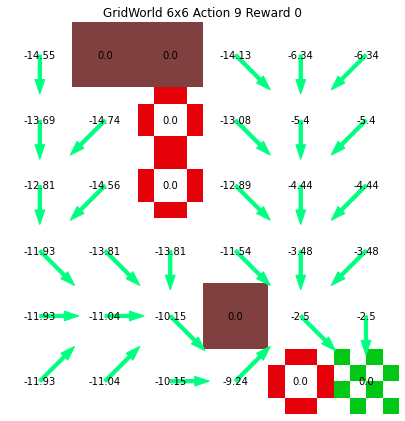

In [6]:
spolicy = gridPolicy(envs)
vp = policyIteration(envs, spolicy, 20, 20)
envs.render(vp, spolicy)

## Método Monte-Carlo

In [7]:
def MC(env:Environment, policy:Policy, alpha:float, 
       k:int = 10, gamma:float = 0.99, samples: int=15):
    assert k > 0, "k needs to be am integer greater or equal to 1 iteration."
    assert (gamma >= 0) and (gamma <= 1), "Gamma discount factor must be in the interval [0,1]"
    assert (alpha > 0) and (alpha <= 1), "Alpha must be a float in (0,1]"
    actions = env.actionSpace
    states = env.stateSpace
    V = np.zeros(env.shape, dtype=np.float32)
    #Defien a crawler to explore the routes
    # Returns the return reward of the trayectory
    def crawler(initState:tuple):
        nonlocal env, policy, gamma
        G = 0.0
        step = 0
        obs = env.reset(initState)
        # Checking if the environment restarted in a invalid position
        if obs is None:
            return 0
        done = False
        while not done:
            action = policy.getAction(obs)
            obs, reward, done = env.step(action)
            G += np.power(gamma, step) * reward
            step =+ 1
        return G
    # Do the iterations
    for _ in range(k):
        # For each state
        for state in states:
            G_s = 0.0
            # Collect n samples
            for _ in range(samples):
                G_s += crawler(state)
            # Average the quantity of the samples E[G_t]
            G_s = G_s / samples
            # Update with the expectation of G
            V[state] = V[state] + alpha * (G_s - V[state])

    return V
    

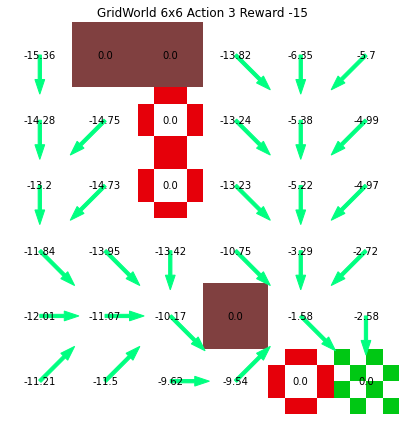

In [8]:
vmc = MC(envs, spolicy, 0.1, 50, samples=30)
envs.render(vmc, spolicy)

## Método de diferencias temporales

In [9]:
def TD0(env:Environment, policy:Policy, alpha:float, 
       k:int = 10, gamma:float = 0.99):
    assert k > 0, "k needs to be am integer greater or equal to 1 iteration."
    assert (gamma >= 0) and (gamma <= 1), "Gamma discount factor must be in the interval [0,1]"
    assert (alpha > 0) and (alpha <= 1), "Alpha must be a float in (0,1]"
    actions = env.actionSpace
    states = env.stateSpace
    V = np.zeros(env.shape, dtype=np.float32)
    for _ in range(k):
        i = np.random.randint(0, len(states))
        state = states[i]
        # Get to the start with state
        obs = env.reset(state)
        if obs is None:
            # Jumps the rest and leaves V at zero
            continue
        done = False
        # Do steps on the environment until reaches a terminal state
        while not done:
            action = policy.getAction(obs)
            obs, reward, done = env.step(action)
            if isinstance(obs, dict):
                obs = obs["agent"]
            # Update the value function
            tdTarget = reward + gamma * V[obs]
            tdError = tdTarget - V[state]
            V[state] = V[state] + alpha * (tdError)
            state = obs
    return V

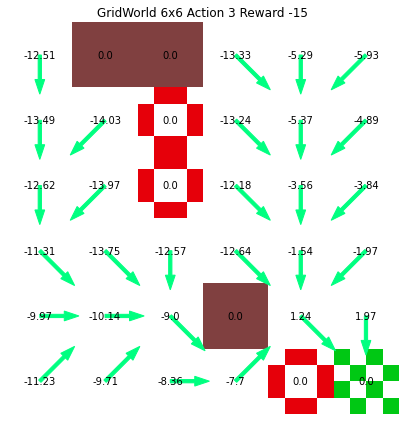

In [10]:
vtd = TD0(envs, spolicy, 0.1, 1000)
envs.render(vtd, spolicy)

## Gym
Es turno de usar la paqueteria de GYM con sus API. Para esta parte se comenzará con un entorno sencillo.

In [11]:
"""# Este código solo es necesario en colab o en entornos
# de computadoras  son sistemas minimalistas
!sudo apt update
!apt install python-opengl
!apt install ffmpeg
!sudo apt-get install xvfb
!pip3 install pyvirtualdisplay

# Virtual display
from pyvirtualdisplay import Display

virtual_display = Display(visible=0, size=(1280, 720))
virtual_display.start()

# Function to render environments based on Classic control renderer
render = lambda e : plt.imshow(e.render(mode = "rgb_array"))"""

'# Este código solo es necesario en colab o en entornos\n# de computadoras  son sistemas minimalistas\n!sudo apt update\n!apt install python-opengl\n!apt install ffmpeg\n!sudo apt-get install xvfb\n!pip3 install pyvirtualdisplay\n\n# Virtual display\nfrom pyvirtualdisplay import Display\n\nvirtual_display = Display(visible=0, size=(1280, 720))\nvirtual_display.start()\n\n# Function to render environments based on Classic control renderer\nrender = lambda e : plt.imshow(e.render(mode = "rgb_array"))'

In [12]:
import gym

In [13]:
env = gym.make("CartPole-v0")
obs = env.reset()
print(env.action_space)

Discrete(2)


In [14]:
for _ in range(10):
    obs, reward, done, info = env.step(env.action_space.sample())
    if done:
        env.reset()
#render(env)
print("Position {} Velocity {} Angle {} Angular velocity {}".format(*obs))

Position -0.11266880111926642 Velocity -0.4135594866620206 Angle 0.07133748792668423 Angular velocity 0.5996513003504667


## Problemática
En este Taller aun no se ven el manejo de señales continuas. Esto claramente es un problema de tratabilidad usando los métodos tabulares propuestos hasta el momento. Una manera de solucionar esto es proponer una discretización de los estados. Esto nos genera algunos problemas dependiendo de se discretiza estas señales.

Por defecto el entorno de CartPole, cada paso los toma en cantidades discretas de tiempo igual a 0.02 s.

Para tratar la señal o al estado, se puede proponer dado su contradominio unas simples reglas basadas en intervalos.


In [15]:
# Some globals variables
POSITION_STEP = 0.25
ANGLE_STEP = 0.025
VEL_STEP = 0.25
ANGVEL_STEP = 0.25
VEL_LIM = 5
ANGVEL_LIM = 10

limitDis = lambda l, s: (abs(l) // s) * s

def discreteSpacePole():
    def doList(step, limit):
        limit = limitDis(limit, step)
        lowHigh = (limit // step) * step
        return np.arange(-limit, limit + step, step, dtype=np.float32)
    positions = doList(POSITION_STEP, 4.8)
    angles = doList(ANGLE_STEP, 0.418)
    vels = doList(VEL_STEP, VEL_LIM)
    angVel = doList(ANGVEL_STEP, ANGVEL_LIM)
    lens = (len(positions),len(angles), len(vels), len(angVel))
    print("Positions: {}, Angles: {}, Velocities: {}, AngularVelocities: {}".format(*lens))
    print("Total combinations or states ",lens[0]*lens[1]*lens[2]*lens[3])
    stateSpace = {"positions":positions,
               "angles":angles,
               "velocities":vels,
               "angularVelocities":angVel
               }
    V = np.zeros(lens, dtype=np.float32)
    return stateSpace, V

def discreteObsPole(obs, 
                 positionStep = POSITION_STEP, 
                 angleStep = ANGLE_STEP,
                 velStep = VEL_STEP,
                 angVelStep = ANGVEL_STEP,
                 velocityStep = ANGVEL_LIM,
                 velocityLimit = VEL_LIM,
                 angVelLimit = ANGVEL_LIM
                 ):
    """
    From CartPole documentation:
     Observation:
        Type: Box(4)
        Num     Observation               Min                     Max
        0       Cart Position             -4.8                    4.8
        1       Cart Velocity             -Inf                    Inf
        2       Pole Angle                -0.418 rad (-24 deg)    0.418 rad (24 deg)
        3       Pole Angular Velocity     -Inf                    Inf
    returns
    -------
    discrete state, discrete state positions in a table
    """
    def dd(q, step, limit):
        limit = limitDis(limit, step)
        if q <= -limit or q >= limit:
            return limit * np.sign(q), 0 if q < 0 else int((2 * limit) // step + 1)
        q = (abs(q) // step) * step * np.sign(q)
        i = int((q + limit) // step)
        if i >= (2 * limit // step + 1):
            return (2 * limit // step )
        return q, i
        
    x,xDot,theta,thetaDot = obs
    x, xi = dd(x, positionStep, 4.8)
    xDot, xDoti = dd(xDot, velStep, velocityLimit)
    theta, thetai = dd(theta, angleStep, 0.418)
    thetaDot, thetaDoti = dd(thetaDot, angVelStep, angVelLimit)

    return (x, xDot, theta, thetaDot), (xi, xDoti, thetai, thetaDoti)

In [16]:
spaceD, V = discreteSpacePole()

Positions: 39, Angles: 33, Velocities: 41, AngularVelocities: 81
Total combinations or states  4274127


In [17]:
V.shape

(39, 33, 41, 81)

In [18]:
spaceD["velocities"]

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75,  5.  ], dtype=float32)

In [19]:
spaceD["angles"]

array([-4.0000001e-01, -3.7500000e-01, -3.4999999e-01, -3.2499999e-01,
       -2.9999998e-01, -2.7499998e-01, -2.4999997e-01, -2.2499996e-01,
       -1.9999996e-01, -1.7499995e-01, -1.4999995e-01, -1.2499994e-01,
       -9.9999934e-02, -7.4999928e-02, -4.9999923e-02, -2.4999917e-02,
        8.9406967e-08,  2.5000095e-02,  5.0000101e-02,  7.5000107e-02,
        1.0000011e-01,  1.2500009e-01,  1.5000013e-01,  1.7500016e-01,
        2.0000014e-01,  2.2500011e-01,  2.5000015e-01,  2.7500018e-01,
        3.0000016e-01,  3.2500014e-01,  3.5000017e-01,  3.7500021e-01,
        4.0000018e-01], dtype=float32)

In [20]:
discreteObsPole(obs)

((-0.0, -0.25, 0.05, 0.5), (19, 19, 17, 42))

### Clases politica para CartPole

In [21]:
class polePolicy(Policy):
    def __init__(self, stateShapeSpace:tuple, discreteActions:int):
        self.pi = np.zeros(stateShapeSpace, dtype=np.uint8)
        self._shape = stateShapeSpace
        self.actions = discreteActions
        self.greedy = False
        self.randomInit()

    def randomInit(self):
        self.pi = np.random.randint(0, self.actions, size= self.shape)

    def update(self, state, action):
        if isinstance(state, dict):
            state = state["agent"]
        self.pi[state] = action

    def getAction(self, state):
        if isinstance(state, dict):
            state = state["agent"]
        try:
            return self.pi[state]
        except:
            new = []
            for i,j in zip(state, self.shape):
                if i >= j:
                    new += [j-1]
                else:
                    new += [i]
            return self.pi[new]

    @property
    def n(self):
        return self.actions
    
    @property
    def shape(self):
        return self.pi.shape

class poleEGPolicy(polePolicy):
    def __init__(self, stateShapeSpace:tuple, discreteActions:int, 
                 epsilon:float, epsilonLife:int=1000, minEpsilon:float = 0.1):
        assert epsilon >= 0 and epsilon <= 1, "Epsilon must be in [0,1]"
        assert minEpsilon >= 0 and minEpsilon <= 1, "Epsilon must be in [0,1]"
        self._epsilon = epsilon
        self.minEpsilon = minEpsilon
        self.steps = 0
        self.life = epsilonLife
        super().__init__(stateShapeSpace, discreteActions)

    def getAction(self, state):
        if self.greedy:
            return super().getAction(state)
        if np.random.uniform() <= self.epsilon:
            return np.random.randint(0, self.actions)
        else:
            return super().getAction(state)

    def reset(self):
        self.steps = 0

    @property
    def epsilon(self):
        # linear decay
        e = self._epsilon * (1 - self.steps / self.life)
        self.steps += 1
        return max(self.minEpsilon, e)

In [22]:
policySARSA = poleEGPolicy(V.shape, 2, 0.9)
policyQL = poleEGPolicy(V.shape, 2, 0.9)

In [23]:
def evaluatePolicy(env, policy, samples):
    res = []
    policy.greedy = True
    for _ in range(samples):
        obs = env.reset()
        done = False
        G = 0
        while not done:
            # Each step on the episode
            obsD, obsDi = discreteObsPole(obs)
            action = policy.getAction(obsDi)
            obs, reward, done, info = env.step(action)
            G += reward
        res += [G]
    policy.greedy = False
    return np.mean(res)

## SARSA

In [24]:
def SARSA(env:gym.Env, policy:Policy, episodes:int, gamma:float, alpha:float, evaIt: int = 10**2):
    assert (gamma >= 0) and (gamma <= 1), "Gamma discount factor must be in the interval [0,1]"
    assert (alpha >= 0) and (alpha <= 1), "alpha discount factor must be in the interval [0,1]"
    assert episodes > 0, "episodes needs to be am integer greater or equal to 1 iteration."
    Q = np.zeros((*policy.shape, policy.actions), dtype=np.float16)
    learning = []
    for episode in range(episodes):
        if episode % evaIt == 0:
            learning += [evaluatePolicy(env, policy, 30)]
        obs = env.reset()
        done = False
        # Initial action processing
        # This part is a bit AdHoc to out discrete proposal for 
        # this environment and more alike
        obsD, obsDi = discreteObsPole(obs)
        action = policy.getAction(obsDi)
        while not done:
            # Each step on the episode
            obs, reward, done, info = env.step(action)
            obs2D, obs2Di = discreteObsPole(obs)
            action2 = policy.getAction(obs2Di)
            SA = (*obsDi, action)
            S2A2 = (*obs2Di, action2)
            try:
                tdTarget = reward + gamma * Q[S2A2]
            except:
                tdTarget = reward
            tdError = tdTarget -  Q[SA]
            Q[SA] = Q[SA] + alpha * tdError
            # Updating the policy given the new values
            # As the update was just for SA, is the only
            # getting updated on the policy
            Qs = Q[obsDi]
            greedyAction = np.argmax(Qs)
            policy.update(obsDi, greedyAction)
            # Update the new states
            obsDi = obs2Di
            action = action2
    fig = plt.figure(dpi=150)
    plt.title("SARSA: Acumulated Reward per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Acumulate Reward")
    plt.plot(range(0,len(learning)*evaIt, evaIt), learning)
    return Q

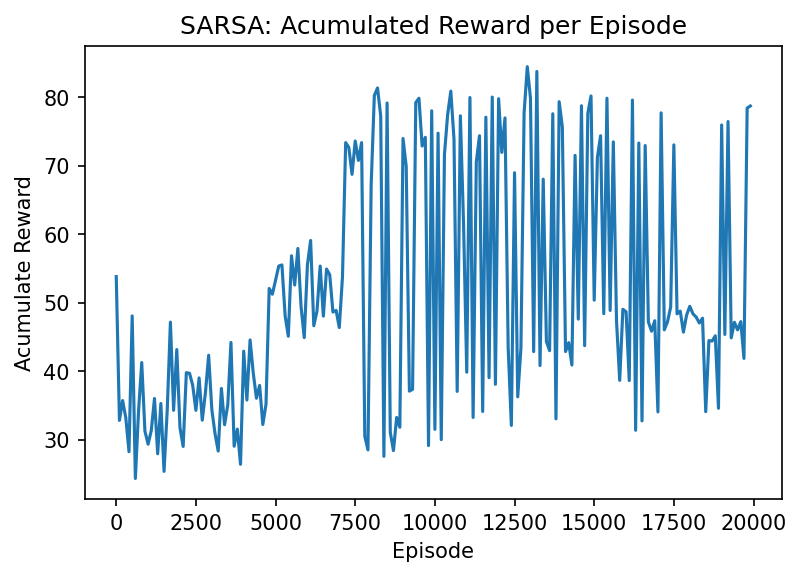

In [25]:
poleQ = SARSA(env, policySARSA, 2*10**4, 0.99, 0.01)

## Q-Learning

In [26]:
def QLearning(env:gym.Env, policy:Policy, episodes:int, gamma:float, alpha:float, evaIt = 10**2):
    assert (gamma >= 0) and (gamma <= 1), "Gamma discount factor must be in the interval [0,1]"
    assert (alpha >= 0) and (alpha <= 1), "alpha discount factor must be in the interval [0,1]"
    assert episodes > 0, "episodes needs to be am integer greater or equal to 1 iteration."
    Q = np.zeros((*policy.shape, policy.actions), dtype=np.float16)
    learning = []
    for episode in range(episodes):
        if episode % evaIt == 0:
            learning += [evaluatePolicy(env, policy, 30)]
        obs = env.reset()
        done = False
        obsD, obsDi = discreteObsPole(obs)
        while not done:
            # Each step on the episode
            action = policy.getAction(obsDi)
            obs, reward, done, info = env.step(action)
            obs2D, obs2Di = discreteObsPole(obs)
            SA = (*obsDi, action)
            try:
                maxQ = np.max(Q[obs2Di])
            except:
                maxQ = 0
            tdError = reward + gamma * maxQ - Q[SA]
            Q[SA] = Q[SA] + alpha * tdError
            # Updating the policy given the new values
            # As the update was just for SA, is the only
            # getting updated on the policy
            Qs = Q[obsDi]
            greedyAction = np.argmax(Qs)
            policy.update(obsDi, greedyAction)
            obsDi = obs2Di
    fig = plt.figure(dpi=150)
    plt.title("Q-learning: Acumulated Reward per Episode")
    plt.xlabel("Episode")
    plt.ylabel("Acumulate Reward")
    plt.plot(range(0,len(learning)*evaIt, evaIt), learning)
    return Q

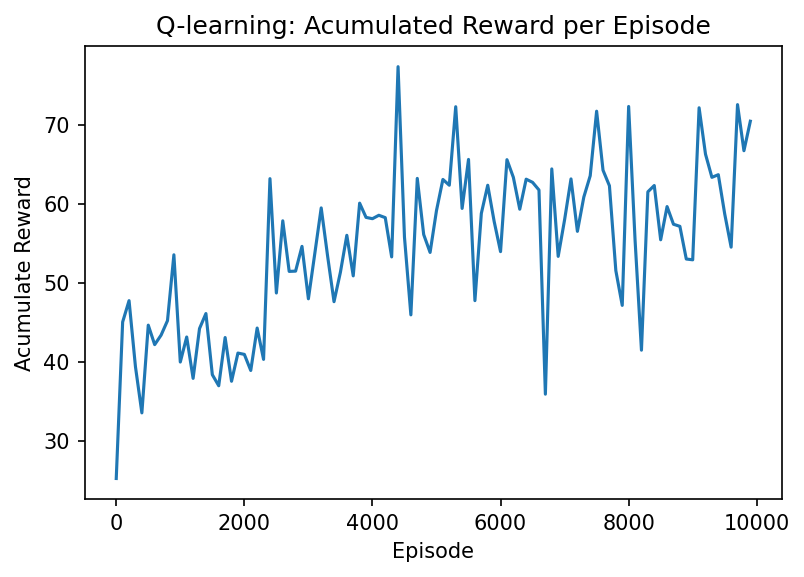

In [27]:
poleQQL = QLearning(env, policyQL, 10**4, 0.99, 0.01)